## Library setup

In [6]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hsankesara_flickr_image_dataset_path = kagglehub.dataset_download('hsankesara/flickr-image-dataset')

print('Data source import complete.')

Using Colab cache for faster access to the 'flickr-image-dataset' dataset.
Data source import complete.


In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
from collections import Counter

# By setting a random seed, we ensure that the sequence of random numbers generated during training,
                                                  # remains the same across different runs of the code.
# keras.utils.set_random_seed(111)

# Data and Pre-processing

In [8]:
# Path to the images
IMAGES_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
# Path to the captions
CAPTIONS_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Fixed length allowed for any sequence
SEQ_LENGTH = 24

# Vocabulary size
VOCAB_SIZE = 13000

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Batch size
BATCH_SIZE = 64

# Number of epochs
EPOCHS = 10

In [9]:
# Loads captions (text) data and maps them to corresponding images.
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()[1:]
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Each image is repeated five times for the five different captions.
            # Image name and captions are separated using a comma
            try:
                img_name, _, caption = line.split("| ")
                # There is one row in the dataset which causes ValueError when splitting.
                # Handling the error:
            except ValueError:
                img_name, caption = line.split("| ")
                caption = caption[4:]

            img_name = os.path.join(IMAGES_PATH, img_name.strip())
            # Removing caption that are either too short to too long
            tokens = caption.strip().split()
            if len(tokens) < 4 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # A start and an end token must be added to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

# Splits the dataset into training, validation, and test sets
def train_val_split(caption_data, validation_size=0.2, test_size=0.02, shuffle=True):
    # Getting the list of all image names
    all_images = list(caption_data.keys())

    # Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)

    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}

    # Return the splits
    return training_data, validation_data, test_data

# Loading the dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)

# Spliting the dataset
train_data, validation_data, test_data = train_val_split(captions_mapping)
print(f"Total number of samples: {len(captions_mapping)}")
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of validation samples: {len(validation_data)}")
print(f"----> Number of test samples: {len(test_data)}")

Total number of samples: 26144
----> Number of training samples: 20915
----> Number of validation samples: 5124
----> Number of test samples: 105


## Defining **the vectorizer** with custom standardization and image augmentation

In [10]:
def custom_standardization(input_string):
    # Lowercasing all of the captions
    lowercase = tf.strings.lower(input_string)
    # Charecters to remove
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890"
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Defining the vectorizer
vectorization = TextVectorization(
    # Number of unique tokens
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    # Maximum length of captions. Padding tokens(zeros) will be added to shorter captions.
    output_sequence_length=SEQ_LENGTH,
    # Standardizing the captions
    standardize=custom_standardization)

# Adapting the vectorizer with the captions
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                       layers.RandomRotation(0.2),
                                       layers.RandomContrast(0.3)])

# Standardizing the text data
text_data = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], text_data))

## Visualizing some of the images along with the corresponding captions

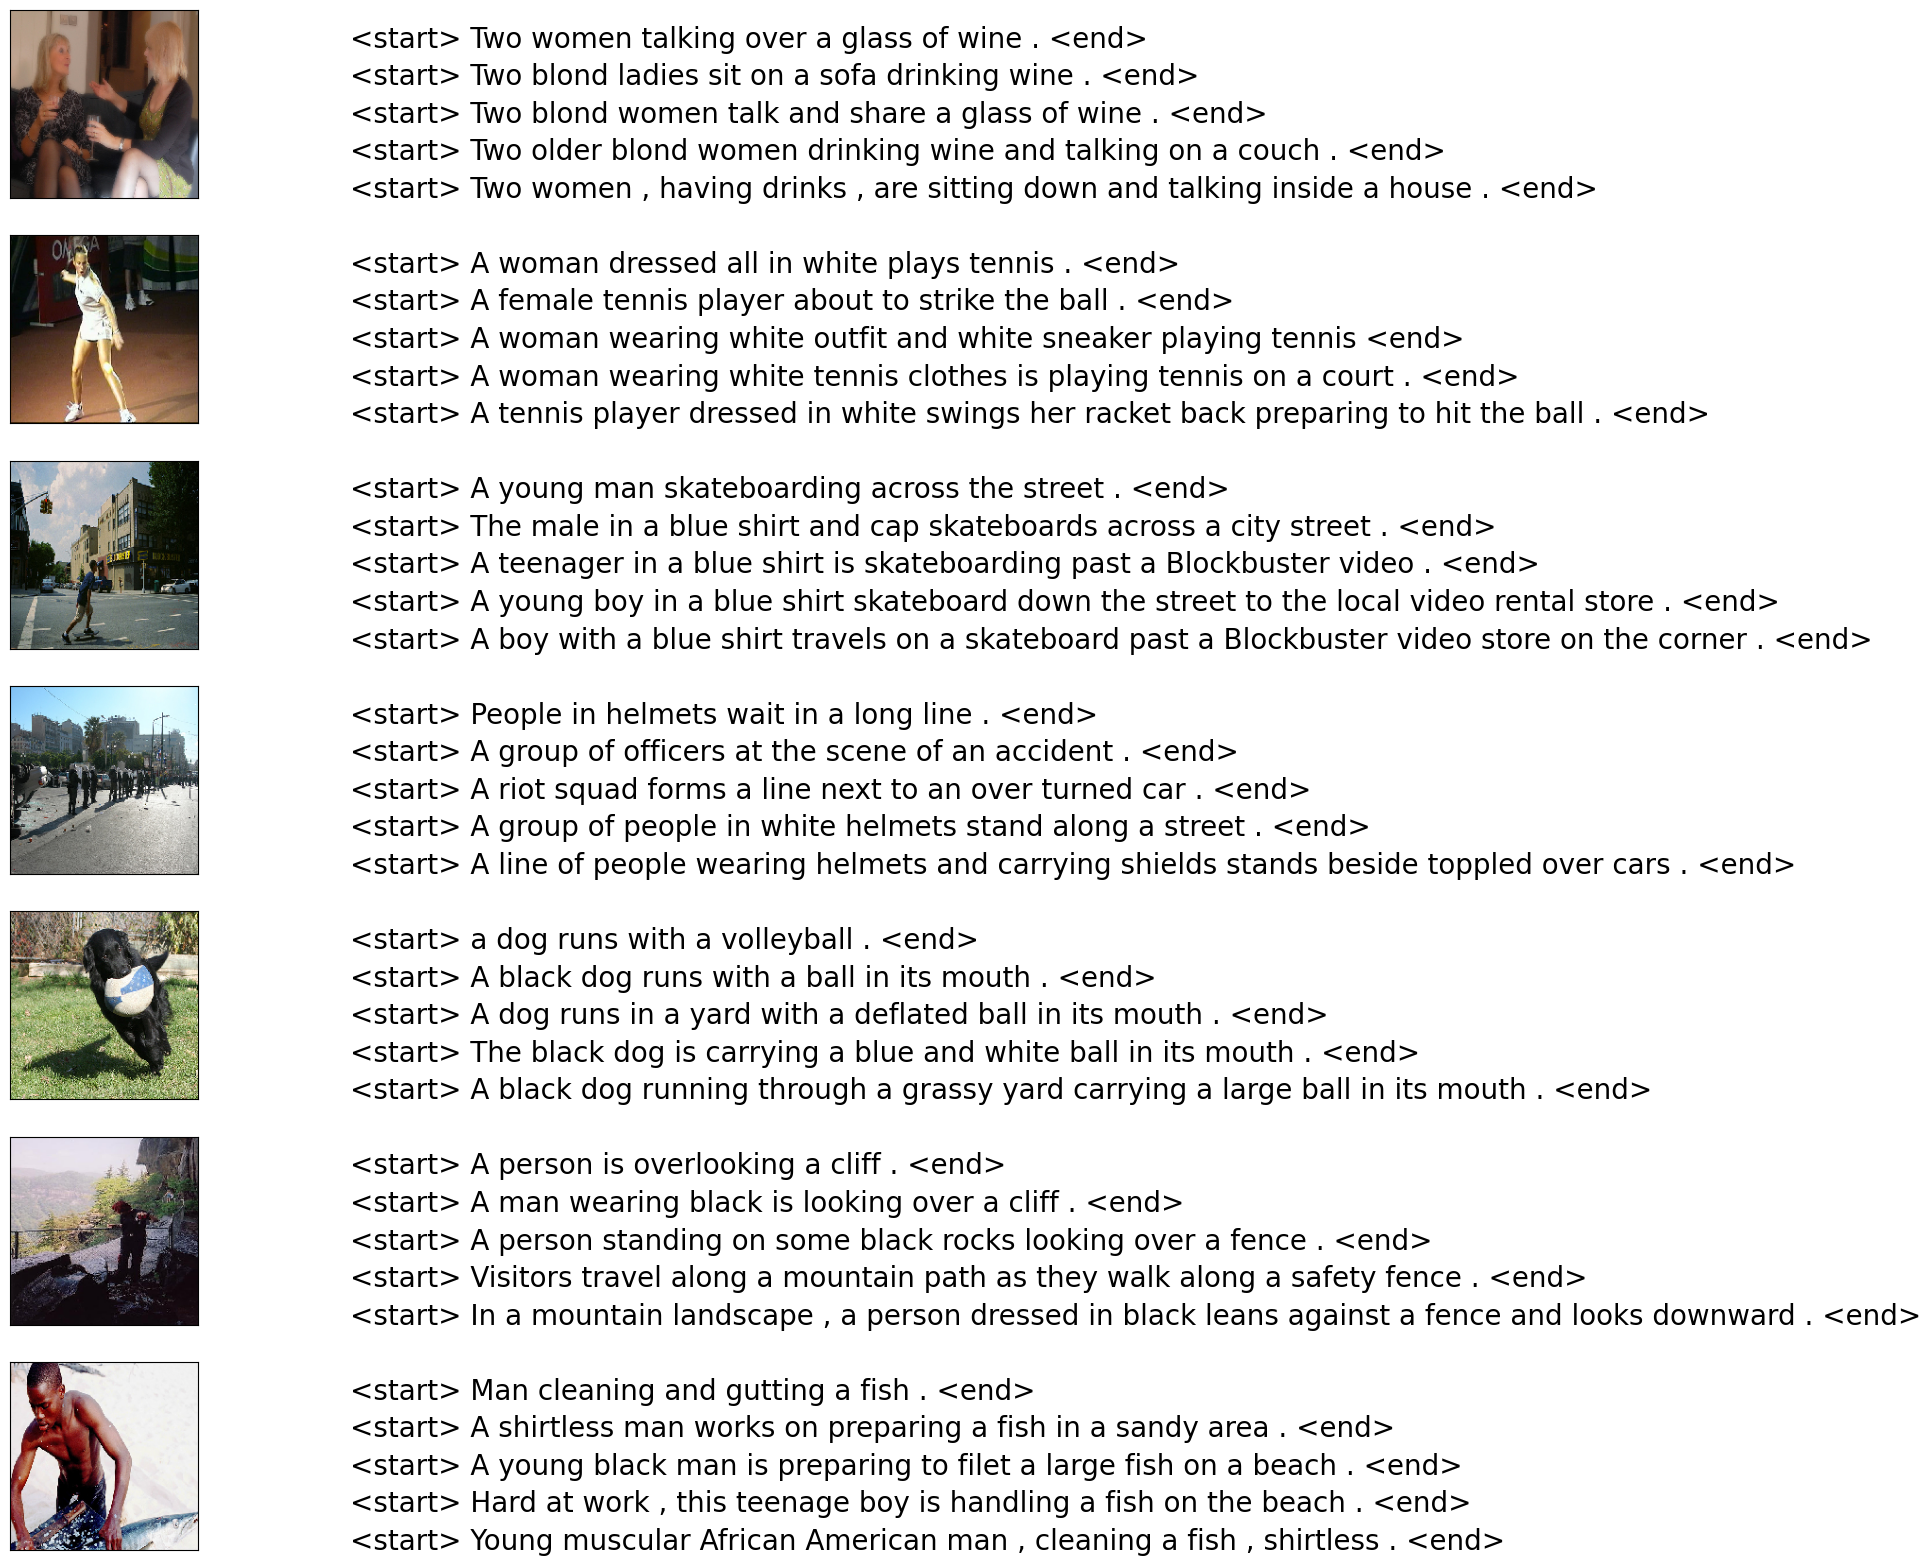

In [11]:
def visualaization(data, num_of_images):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(data.keys())[100:100+num_of_images]:
        captions = data[filename]
        image_load = load_img(filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(train_data, 7)

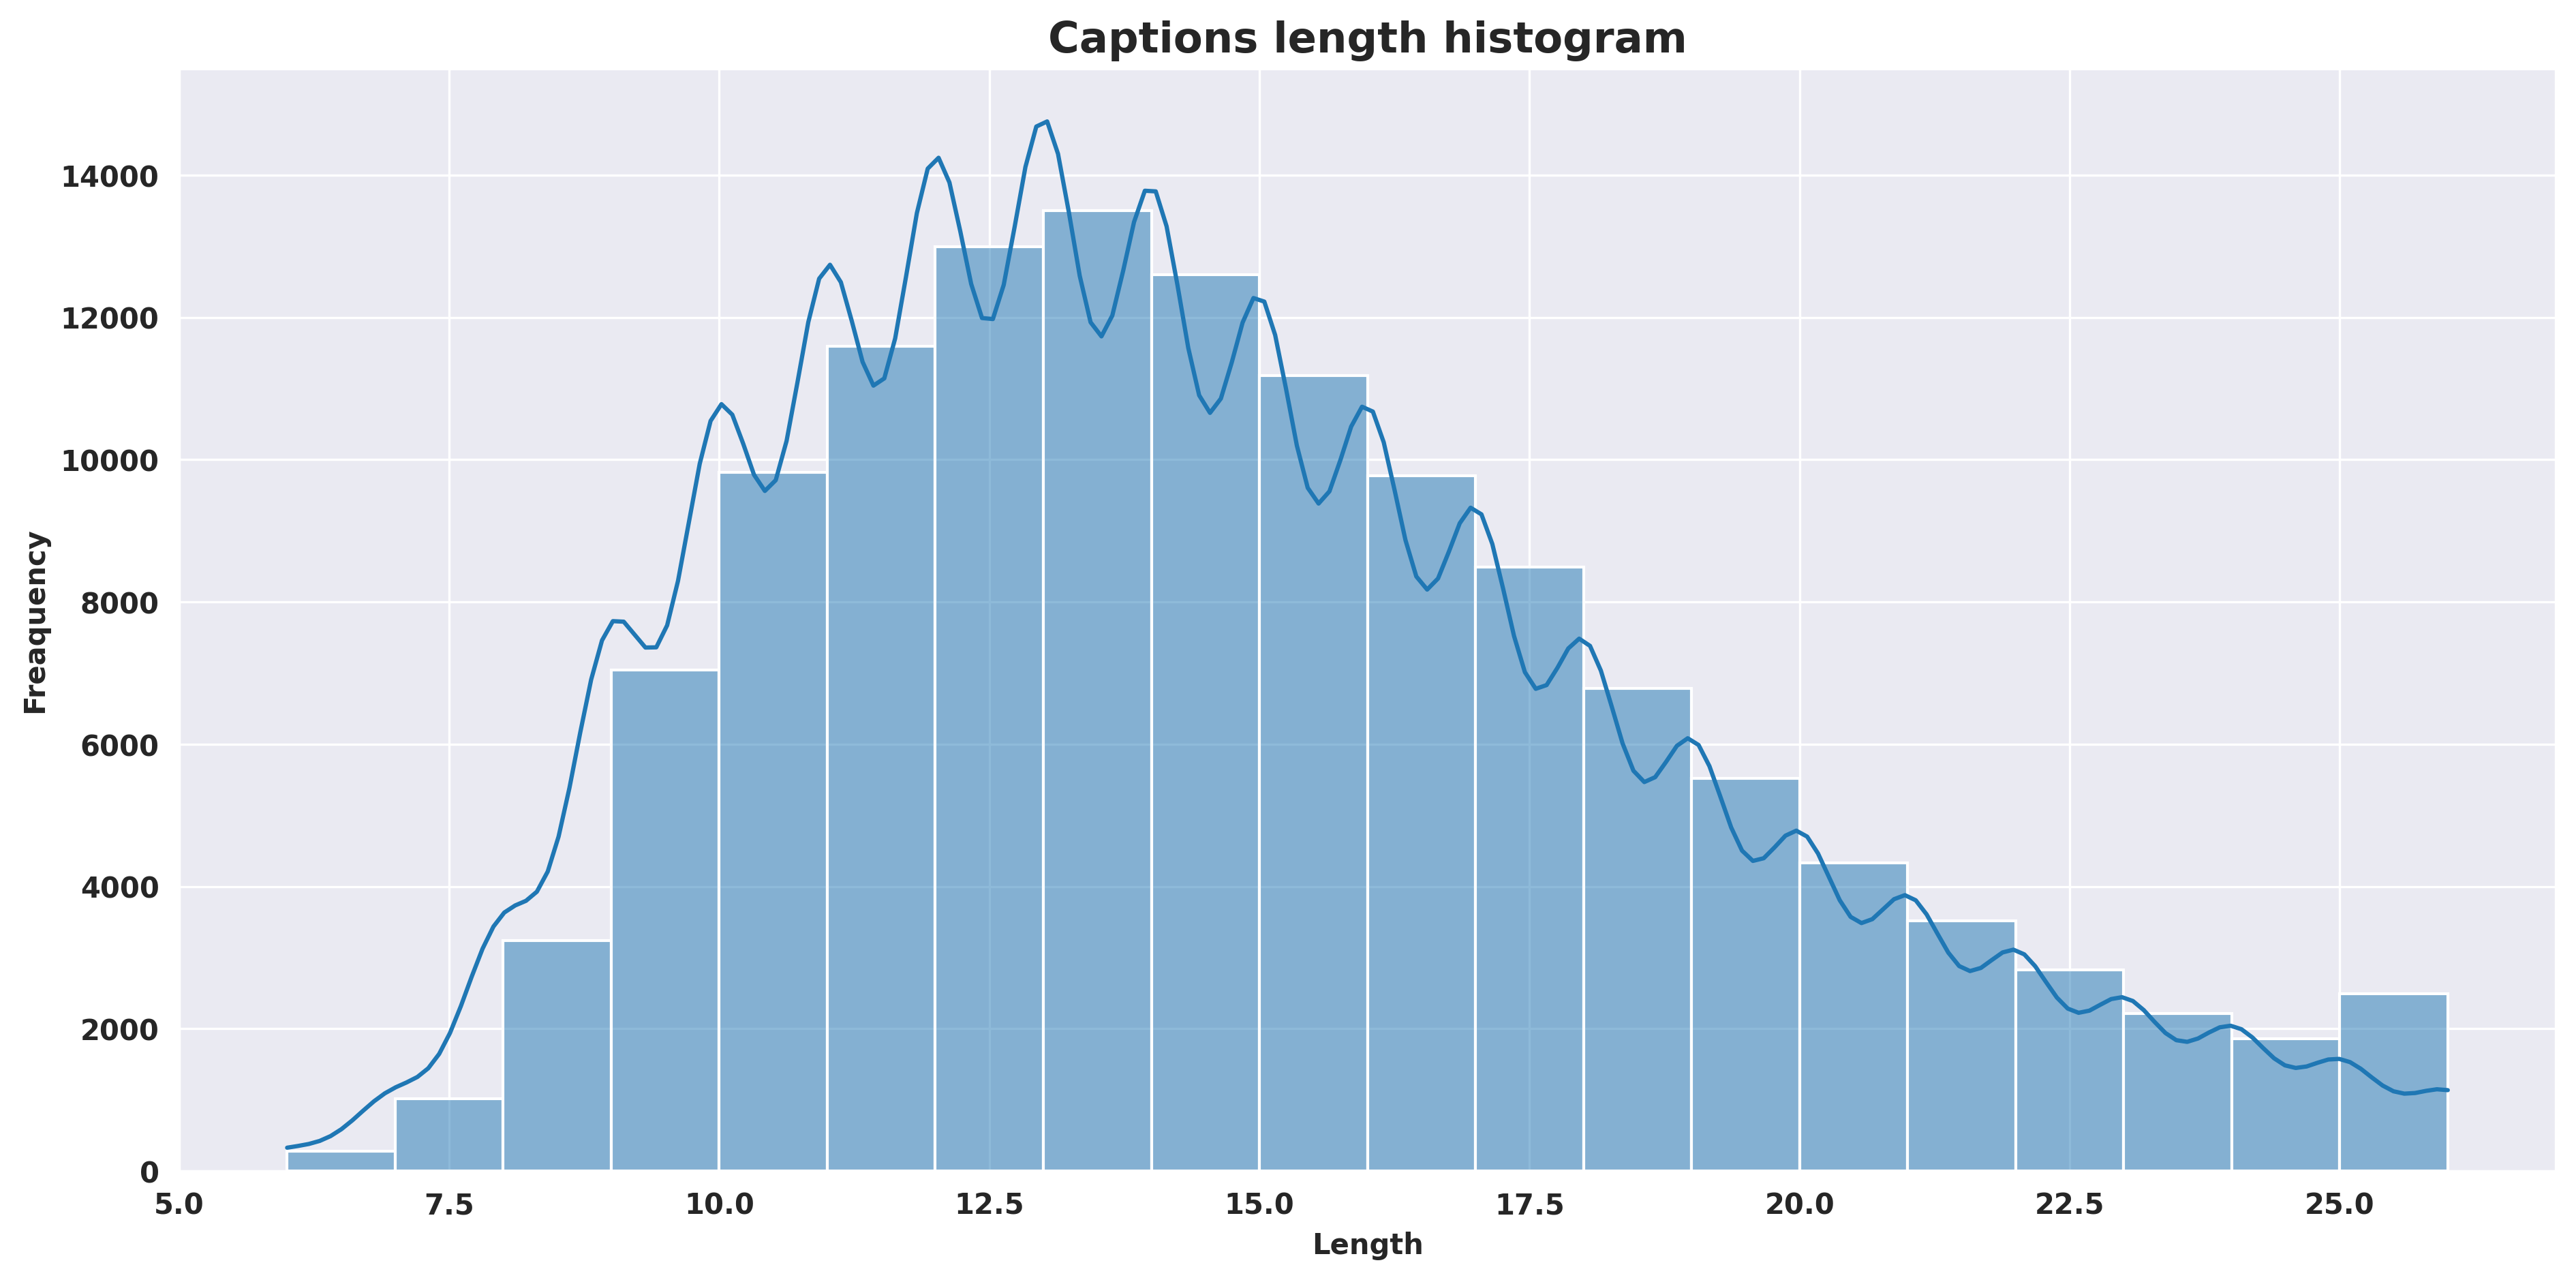

In [12]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(text_data)

In [13]:
def word_occurrences(data):
    # Combining all sentences into a single string
    all_text = ' '.join(data)
    all_text = all_text.replace('a ', '')
    all_text = all_text.replace('<start> ', '')
    all_text = all_text.replace('<end> ', '')
    # Splitting the text into words and count occurrences
    word_counts = Counter(all_text.split())

    words = list(word_counts.keys())[:30]
    values = list(word_counts.values())[:30]

    # Normalize values to be between 0 and 1
    normalized_values = np.array(values) / np.max(values)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in normalized_values])

    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])

    fig.update_layout(title_text='Word occurrences in captions (except for letter \'a\')', title_font=dict(size=23, family='Balto'))

    fig.show()

word_occurrences(text_data)

# **Data Setup for Model Input**



In [14]:
# Processes the images
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    # Processed images: (None, 299, 299, 3), Vectorized captions: (None, None, 25)
    return decode_and_resize(img_path), vectorization(captions)

# Prepares the dataset
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    # Prefetching the next batch of data based on available resources while the current batch is being processed.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset


# Making the datasets by passing the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

In [15]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 24), dtype=tf.int64, name=None))>

# **Defining** the **Image Captioning** Model



In [16]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False, # Removing the prediction layers
        weights="imagenet")
    # Freezing the model's weights
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=None,
                                              training=training)
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # Positional encoding
        embedded_tokens = self.token_embeddings(inputs) # Input embedding
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # Positional embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(embed_dim=EMBED_DIM,
                                             sequence_length=SEQ_LENGTH,
                                             vocab_size=VOCAB_SIZE,)
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        # If the mask is not None, it means that padding tokens are present in the input sequence.
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            # Masking both padding tokens and future tokens
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=combined_mask,
                                              training=training)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Note that the lengths of the inputs are different and cross-attention handles that.
        cross_attention_output_2 = self.cross_attention_2(query=out_1,
                                              value=encoder_outputs,
                                              key=encoder_outputs,
                                              attention_mask=padding_mask,
                                              training=training)
        out_2 = self.layernorm_2(out_1 + cross_attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)

        preds = self.out(ffn_out)
        return preds

    # Masks future tokens
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1),tf.constant([1, 1], dtype=tf.int32)],axis=0)
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

        print()
        print(f'CNN input shape: {cnn_model.input_shape}')
        print(f'CNN output shape: {cnn_model.output_shape}', end='\n'*2)
        print(f'Encoder input ---> Dense layer shape: {cnn_model.output_shape} ---> (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Encoder output shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})', end='\n'*2)
        print(f'Decoder input 1 (Caption) ---> Positional Embedding shape: (None, {SEQ_LENGTH-1}) ---> (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder input 2 (Embedded image features) shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Decoder output (MH Cross-Attention) shape: (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder prediction (Dense layer) shape: (None, {SEQ_LENGTH-1}, {VOCAB_SIZE})')


    # Calculates the loss, taking into account a mask to handle padding.
    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    # Calculates the accuracy, taking into account a mask to handle padding.
    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        # Creating a binary mask where 1 indicates a valid token, and 0 indicates padding.
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(batch_seq_inp, encoder_out, training=training, mask=mask)
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    # Iterates through each caption for the given image, computes loss and accuracy, updates weights, and trackers.
    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # Applies image augmentation if image_aug is provided.
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=True)

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}

    # Similar to train_step but without updating weights.
    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=False)

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We must list the metrics here so the `reset_states()` can be,
                                                  # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

CNN input shape: (None, 299, 299, 3)
CNN output shape: (None, 100, 1280)

Encoder input ---> Dense layer shape: (None, 100, 1280) ---> (None, 100, 512)
Encoder output shape: (None, 100, 512)

Decoder input 1 (Caption) ---> Positional Embedding shape: (None, 23) ---> (None, 23, 512)
Decoder input 2 (Embedded image features) shape: (None, 100, 512)
Decoder output (MH Cross-Attention) shape: (None, 23, 512)
Decoder prediction (Dense layer) shape: (None, 23, 13000)


# Training the model



In [17]:
# Defining the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping criteria
# Training will stop if there is no improvement in the validation loss for 3 consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate)

# Creating a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Training the model
history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - acc: 0.2191 - loss: 28.7830 - val_acc: 0.3556 - val_loss: 18.1664
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - acc: 0.3528 - loss: 18.0628 - val_acc: 0.3816 - val_loss: 16.5701
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - acc: 0.3758 - loss: 16.5636 - val_acc: 0.3940 - val_loss: 15.8217
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - acc: 0.3902 - loss: 15.7100 - val_acc: 0.4018 - val_loss: 15.3898
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - acc: 0.4006 - loss: 15.1139 - val_acc: 0.4063 - val_loss: 15.1451
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - acc: 0.4080 - loss: 14.6484 - val_acc: 0.4102 - val_loss: 14.9619
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - acc: 0.4158 - loss: 14.2565 - val_acc: 0.4127 - val_loss: 14.8580
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - acc: 0.4221 - loss: 13.9180 - val_acc: 0.4145 - val_loss: 14.8382
Epoch 9/10
327/327 ━━━━━━━━━━━━━

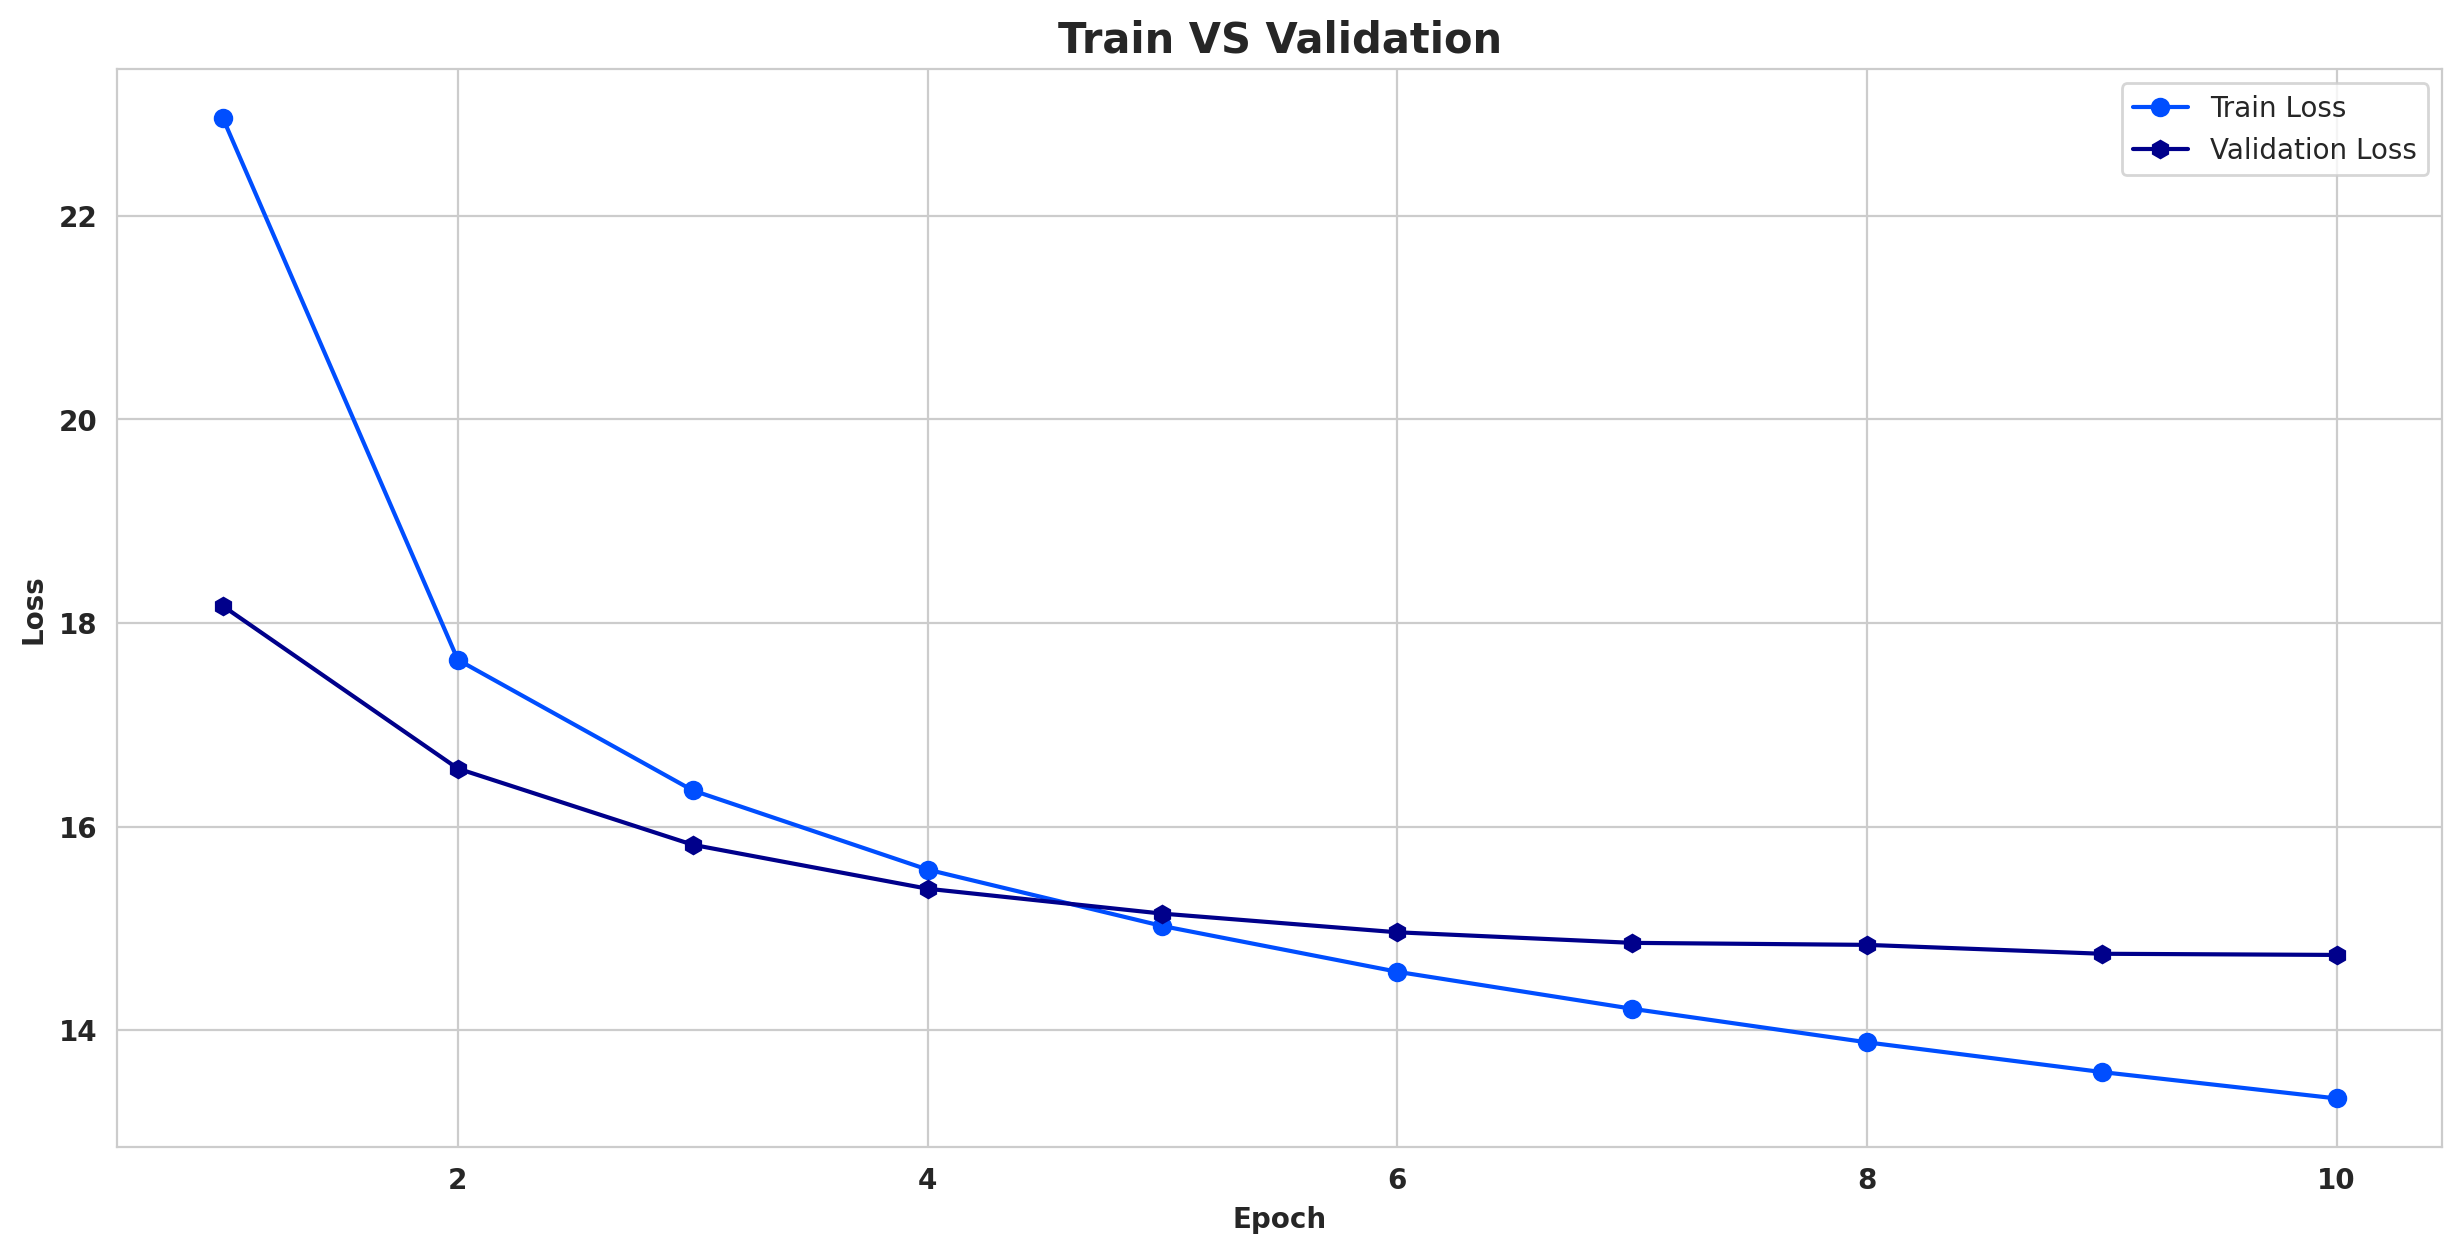

In [18]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#004EFF', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#00008B', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [19]:
vocab = vectorization.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = SEQ_LENGTH - 1
test_images = list(test_data.keys())

def greedy_algorithm(image):
    # Read the image from the disk
    image = decode_and_resize(image)

    # Pass the image to the CNN
    image = tf.expand_dims(image, 0)
    image = caption_model.cnn_model(image)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(image, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    return decoded_caption

In [20]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')
for image_id in test_data:
    cap = greedy_algorithm(image_id)
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()

  0%|          | 0/105 [00:00<?, ?it/s]

In [31]:
# Calculates BLEU score of predictions
def BLEU_score(actual, predicted):
    # Standardizing the actual captions
    processed_actual = []
    for i in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorization(i).numpy() if INDEX_TO_WORD[x] != '']
        cap = ' '.join(cap)
        processed_actual.append(cap)

    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    b1=corpus_bleu(processed_actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(processed_actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(processed_actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(processed_actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-4: {round(b4, 5)}'),
        (f'BLEU-3: {round(b3, 5)}'),
        (f'BLEU-2: {round(b2, 5)}'),
        (f'BLEU-1: {round(b1, 5)}'),
        (f'Generated Caption: {predicted[0]}')
    ]

### Visualizing some of the **test images** along with their corresponding **generated captions**

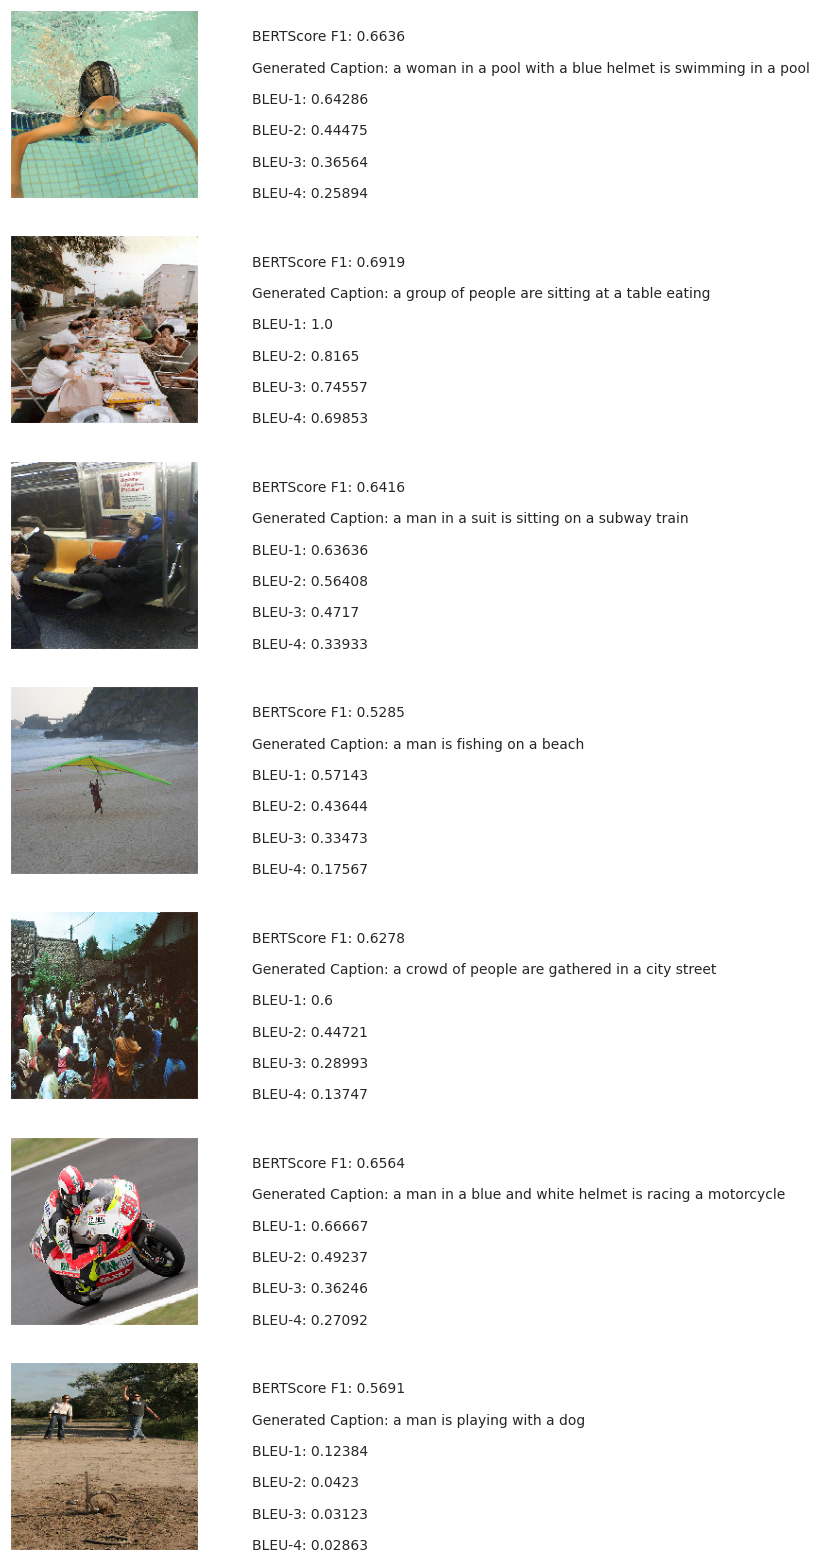

In [53]:
def BLEU_score(actual, predicted):
    # actual: list of 5 reference captions
    # predicted: list containing a single caption (repeated to match len(actual))

    processed_actual = []
    for cap in actual:
        # Convert tokenized caption to string (if needed)
        if not isinstance(cap, str):
            cap = [INDEX_TO_WORD[x] for x in vectorization(cap).numpy() if INDEX_TO_WORD[x] != '']
            cap = ' '.join(cap)
        processed_actual.append(cap)

    # Tokenize (split by space) for corpus_bleu format
    references = [[ref.split() for ref in processed_actual]]
    hypotheses = [predicted[0].split()]

    # Apply smoothing to avoid 0 BLEU for short captions
    smooth = SmoothingFunction().method1

    b1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
    b2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    b3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.34, 0), smoothing_function=smooth)
    b4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

    return [
        f'BLEU-4: {round(b4, 5)}',
        f'BLEU-3: {round(b3, 5)}',
        f'BLEU-2: {round(b2, 5)}',
        f'BLEU-1: {round(b1, 5)}',
        f'Generated Caption: {predicted[0]}'
    ]

# Visualization (unchanged)
def visualization(data, generated_captions, evaluator, num_of_images):
    keys = list(data.keys())  # List of all test images
    images = [np.random.choice(keys) for _ in range(num_of_images)]  # Randomly selected images

    count = 1
    fig = plt.figure(figsize=(6, 20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("<start> ", "").replace(" <end>", "") for x in actual_cap]

        caption = generated_captions[filename]

        caps_with_score = evaluator(actual_cap, [caption] * len(actual_cap))
        bert_res = BERT_score([actual_cap], [caption])
        caps_with_score += [f"BERTScore F1: {bert_res['BERTScore F1']}"]


        image_load = load_img(filename, target_size=(199, 199, 3))
        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0, i, text, fontsize=10)
        count += 1
    plt.show()

# Example call
visualization(test_data, generated_captions, BLEU_score, 7)

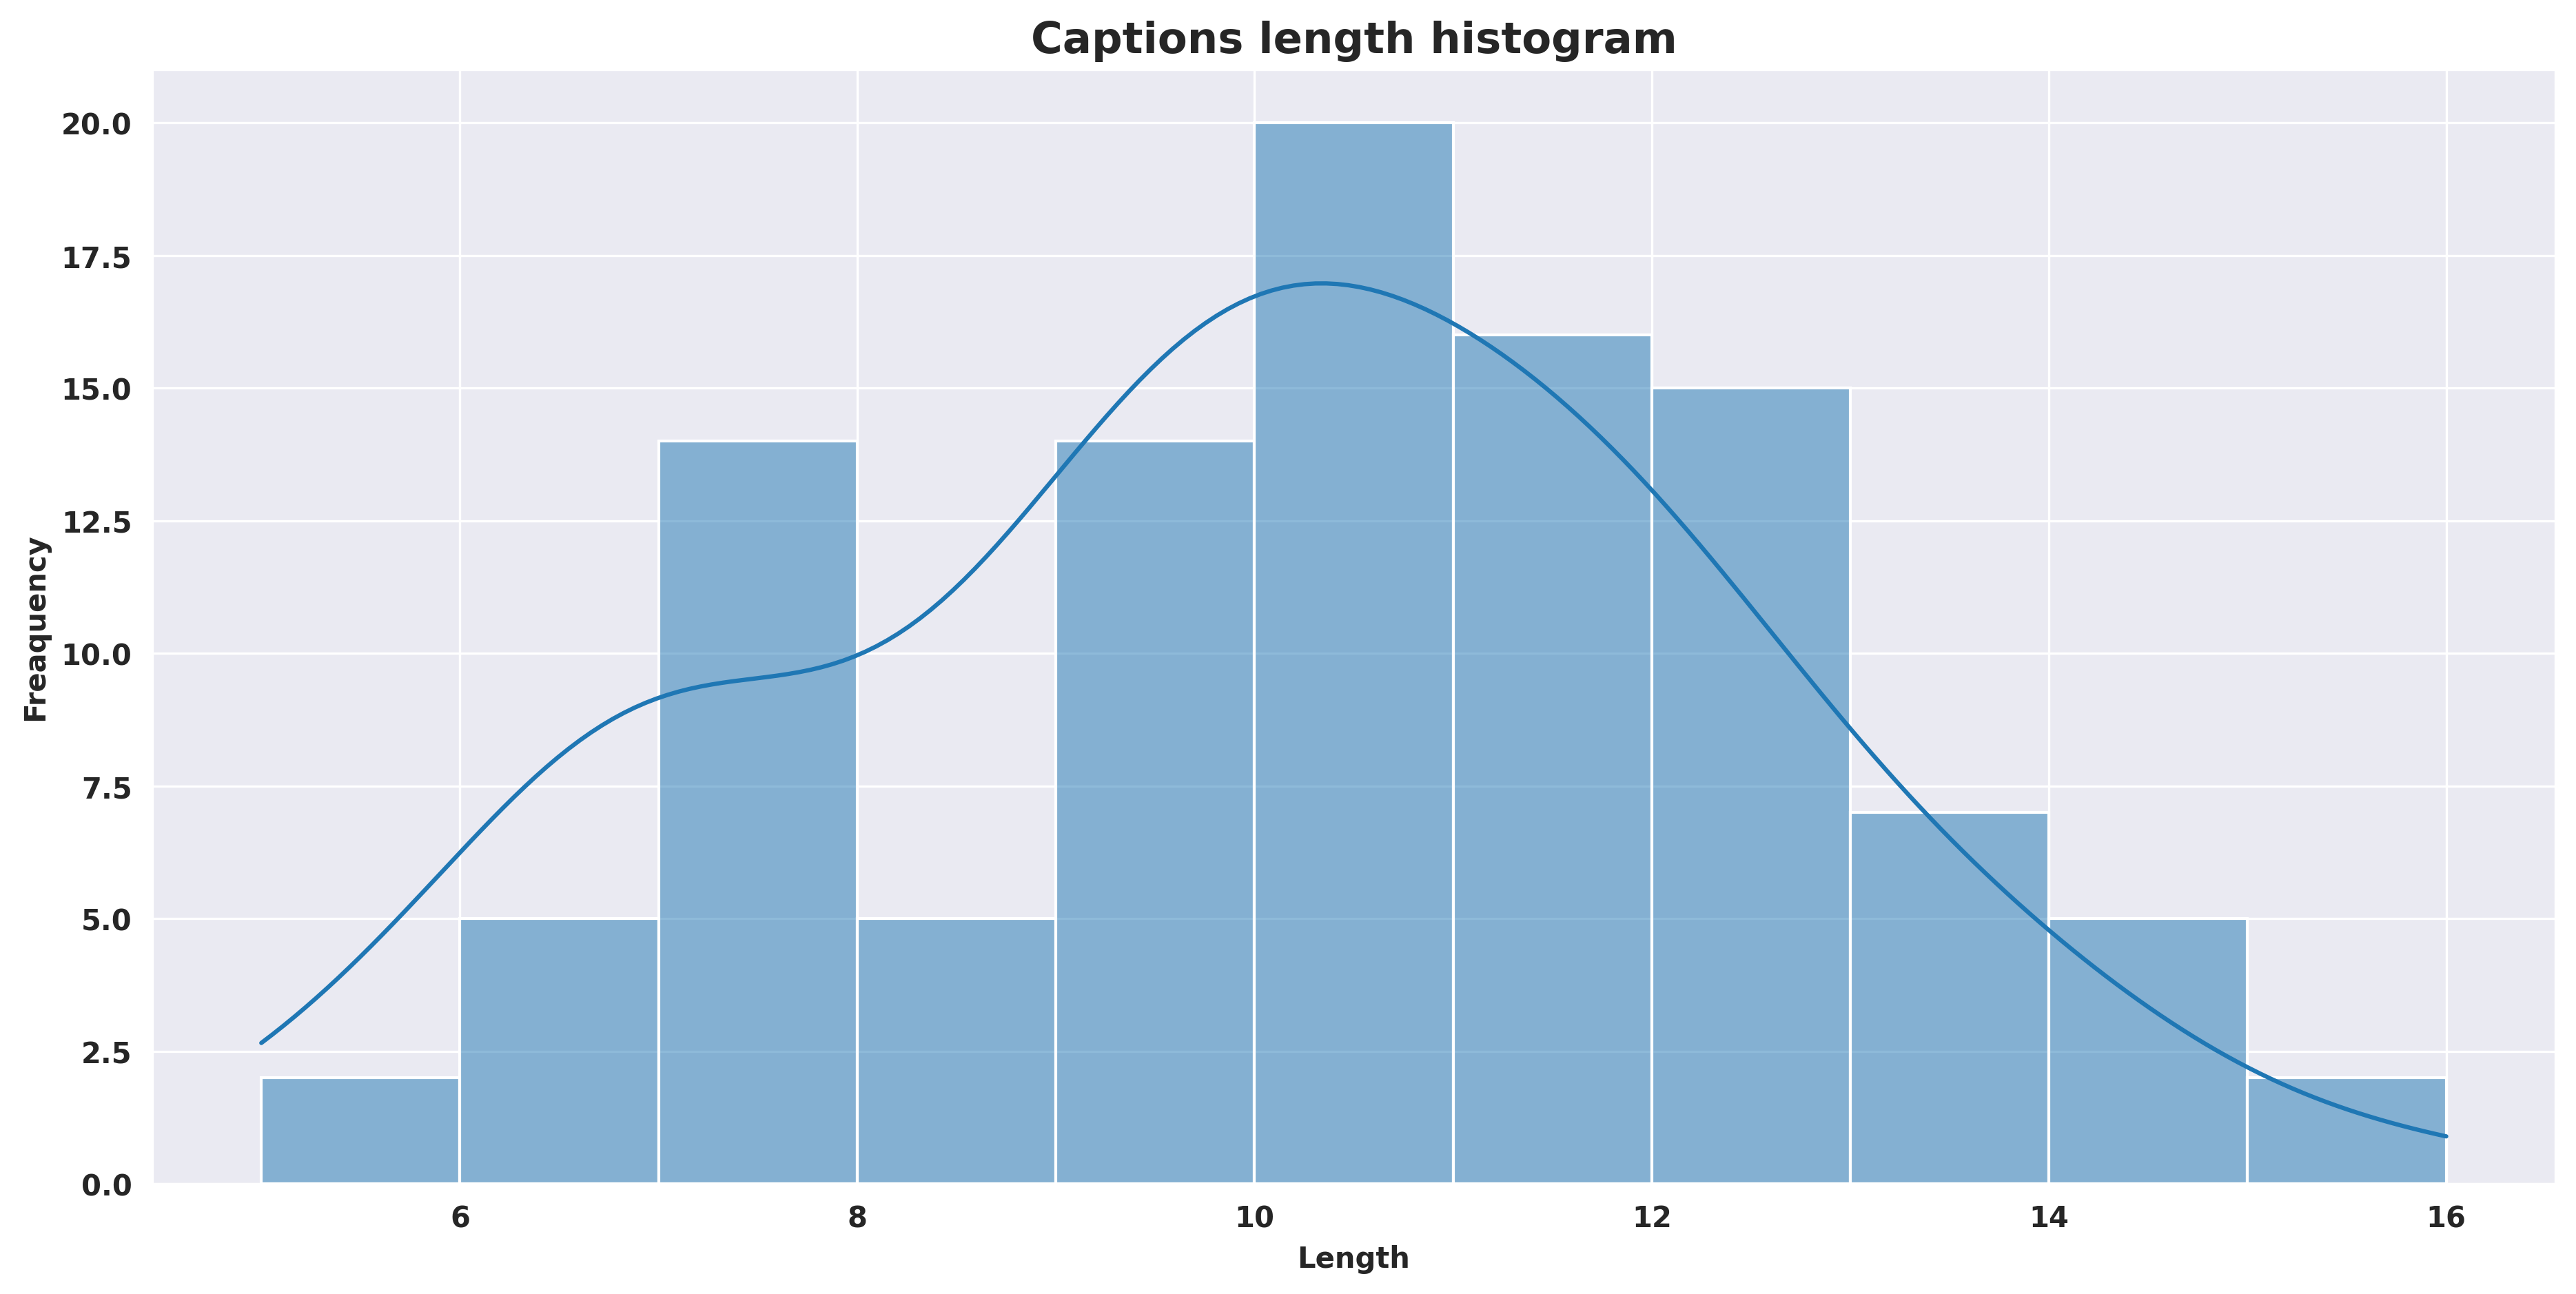

In [23]:
captions_length(list(generated_captions.values()))